In [1]:
!pip install easyocr
!pip install spacy
!python -m spacy download ko_core_news_sm
from google.colab import drive
drive.mount('/content/drive')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 43.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ko_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import cv2
import numpy as np
import re
import easyocr
import spacy
import matplotlib.pyplot as plt

In [20]:
# OCR
reader = easyocr.Reader(['ko', 'en'], gpu=True)

# NLP (spaCy)
nlp = spacy.load("ko_core_news_sm")

In [21]:
PHONE_PATTERN = re.compile(r'(01[016789])[-\s]?\d{3,4}[-\s]?\d{4}')
RRN_PATTERN   = re.compile(r'\d{6}[-\s]?\d{7}')
CAR_PATTERN   = re.compile(r'\d{2,3}[가-힣]\s?\d{4}')

# ⚠️ 주소는 "후보"로만 사용 (판결 ❌)
ADDRESS_PATTERN = re.compile(r'(시|도|구|동|로|길)')


In [22]:
def rule_detect(text: str):
    hits = []

    if PHONE_PATTERN.search(text):
        hits.append("PHONE")
    if RRN_PATTERN.search(text):
        hits.append("RRN")
    if CAR_PATTERN.search(text):
        hits.append("CAR")
    if ADDRESS_PATTERN.search(text):
        hits.append("ADDRESS")

    return hits


In [23]:
def nlp_validate_private(text: str) -> bool:
    """
    개인정보로 볼 수 있는 의미가 있으면 True
    """
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ["PERSON", "LOC", "GPE"]:
            return True
    return False


In [24]:
def should_mosaic_with_reason(text: str):
    rule_hits = rule_detect(text)

    # Rule에서 아무 것도 안 걸리면 안전
    if not rule_hits:
        return False, "NO_RULE_MATCH"

    # Rule 후보가 있으면 NLP로 최종 검증
    nlp_ok = nlp_validate_private(text)

    if nlp_ok:
        return True, f"RULE:{rule_hits} + NLP_CONFIRM"

    # Rule만 있고 NLP가 부정
    return False, f"RULE_ONLY:{rule_hits}"


In [33]:
img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/SNS_OCR/test_sample3.jpg")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

results = reader.readtext(img_rgb)

In [34]:
def expand_bbox(bbox, img_shape, ratio=0.08):
    h, w = img_shape[:2]
    xs = [p[0] for p in bbox]
    ys = [p[1] for p in bbox]

    x1, x2 = min(xs), max(xs)
    y1, y2 = min(ys), max(ys)

    dx = int((x2 - x1) * ratio)
    dy = int((y2 - y1) * ratio)

    return (
        max(0, x1 - dx),
        max(0, y1 - dy),
        min(w, x2 + dx),
        min(h, y2 + dy)
    )


In [35]:
mosaic_img = img_rgb.copy()

for bbox, text, conf in results:
    mosaic, reason = should_mosaic_with_reason(text)

    # 🔍 디버깅 로그 (중요)
    print(f"[TEXT] {text}")
    print(f"  Rule hits: {rule_detect(text)}")
    print(f"  NLP ents : {[(ent.text, ent.label_) for ent in nlp(text).ents]}")
    print(f"  Final    : {mosaic} ({reason})")
    print("-" * 50)

    if not mosaic:
        continue

    x1, y1, x2, y2 = expand_bbox(bbox, img_rgb.shape)

    roi = mosaic_img[y1:y2, x1:x2]
    if roi.size == 0:
        continue

    small = cv2.resize(roi, (16, 16))
    mosaic_block = cv2.resize(
        small,
        (x2 - x1, y2 - y1),
        interpolation=cv2.INTER_NEAREST
    )

    mosaic_img[y1:y2, x1:x2] = mosaic_block


[TEXT] 기"질
  Rule hits: []
  NLP ents : []
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] KIM
  Rule hits: []
  NLP ents : [('KIM', 'OG')]
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] K00
  Rule hits: []
  NLP ents : [('K00', 'OG')]
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] FoORUM
  Rule hits: []
  NLP ents : []
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] #Ts
  Rule hits: []
  NLP ents : []
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] K 0 R E A
  Rule hits: []
  NLP ents : [('0', 'QT')]
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] 1 N S TlT U T E
  Rule hits: []
  NLP ents : [('1', 'QT')]
  Final    : False (NO_RULE_MATCH)
--------------------------------------------------
[TEXT] 20TH
  Rule hits: []


(np.float64(-0.5), np.float64(1655.5), np.float64(2559.5), np.float64(-0.5))

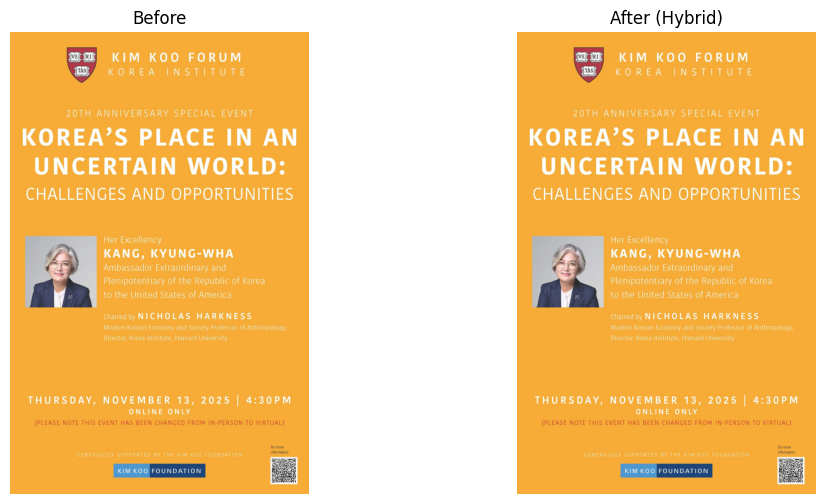

In [36]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.title("Before")
plt.imshow(img_rgb)
plt.axis("off")

plt.subplot(1,2,2)
plt.title("After (Hybrid)")
plt.imshow(mosaic_img)
plt.axis("off")
